In [1]:
def bsm_call_value(S0, K, T, r, sigma):
    from math import log, sqrt, exp
    from scipy import stats
    
    S0 = float(S0)
    d1 = (log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrt(T))
    d2 = (log(S0 / K) + (r - 0.5 * sigma**2) * T) / (sigma * sqrt(T))
    value = (S0 * stats.norm.cdf(d1, 0.0, 1.0) - K * exp(-r * T)*stats.norm.cdf(d2, 0.0, 1.0))
    return value

In [2]:
def bsm_vega(S0, K, T, r, sigma):
    from math import log, sqrt
    from scipy import stats
    
    S0 = float(S0)
    d1 = (log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrt(T))
    vega = S0 * stats.norm.cdf(d1, 0.0, 1.0) * sqrt(T)
    return vega

In [3]:
def bsm_call_imp_vol(S0, K, T, r, C0, sigma_est, it=100):
    for i in range(it):
        sigma_est -= ((bsm_call_value(S0, K, T, r, sigma_est) - C0) / bsm_vega(S0, K, T, r, sigma_est))
    return sigma_est

#### Spot price of underlying is 17.6639 and r = 1%

In [4]:
V0 = 17.6639
r = 0.01

In [5]:
import pandas as pd
import numpy as np
h5 = pd.HDFStore('vstoxx_march_2014.h5', 'r')

In [6]:
h5

<class 'pandas.io.pytables.HDFStore'>
File path: vstoxx_march_2014.h5

In [7]:
type(h5)

pandas.io.pytables.HDFStore

In [8]:
h5.groups()

[/vstoxx_futures (Group) ''
   children := ['axis0' (Array), 'axis1' (Array), 'block0_items' (Array), 'block0_values' (Array), 'block1_items' (Array), 'block1_values' (Array), 'block2_items' (Array), 'block2_values' (Array)],
 /vstoxx_index (Group) ''
   children := ['axis0' (Array), 'axis1' (Array), 'block0_items' (Array), 'block0_values' (Array)],
 /vstoxx_options (Group) ''
   children := ['axis0' (Array), 'axis1' (Array), 'block0_items' (Array), 'block0_values' (Array), 'block1_items' (Array), 'block1_values' (Array), 'block2_items' (Array), 'block2_values' (Array), 'block3_items' (Array), 'block3_values' (VLArray)]]

In [9]:
futures_data = h5['vstoxx_futures']  # loads into DataFrame

In [10]:
options_data = h5['vstoxx_options']

In [11]:
h5.close()

In [12]:
type(futures_data)

pandas.core.frame.DataFrame

In [13]:
futures_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 504 entries, 0 to 503
Data columns (total 5 columns):
DATE         504 non-null datetime64[ns]
EXP_YEAR     504 non-null int64
EXP_MONTH    504 non-null int64
PRICE        504 non-null float64
MATURITY     504 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2)
memory usage: 23.6 KB


In [14]:
options_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46960 entries, 0 to 46959
Data columns (total 7 columns):
DATE         46960 non-null datetime64[ns]
EXP_YEAR     46960 non-null int64
EXP_MONTH    46960 non-null int64
TYPE         46960 non-null object
STRIKE       46960 non-null float64
PRICE        46960 non-null float64
MATURITY     46960 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 2.9+ MB


In [15]:
options_data.sample(20)

,DATE,EXP_YEAR,EXP_MONTH,TYPE,STRIKE,PRICE,MATURITY
46740,2014-03-31,2014,7,P,29.0,9.35,2014-07-18
39711,2014-03-18,2014,8,P,12.0,0.05,2014-08-15
37158,2014-03-13,2014,3,P,45.0,23.55,2014-03-21
19789,2014-02-11,2014,2,C,45.0,0.05,2014-02-21
3463,2014-01-09,2014,1,P,80.0,62.40,2014-01-17
4048,2014-01-10,2014,8,C,15.0,6.60,2014-08-15
16698,2014-02-05,2014,2,C,37.5,0.05,2014-02-21
39057,2014-03-18,2014,3,C,2.0,20.85,2014-03-21
4869,2014-01-13,2014,3,P,70.0,51.50,2014-03-21
14371,2014-01-30,2014,6,P,60.0,39.00,2014-06-20


#### Subset our option data to only include Call data for 2014-03-31

In [16]:
options_data = options_data[(options_data['DATE'] == '2014-03-31') & (options_data['TYPE'] == 'C')]

In [17]:
len(options_data)

395

#### Subset futures data to only include data for 2014-03-31

In [18]:
futures_data = futures_data[(futures_data['DATE'] == '2014-03-31')]

In [19]:
futures_data

,DATE,EXP_YEAR,EXP_MONTH,PRICE,MATURITY
496,2014-03-31,2014,4,17.85,2014-04-18
497,2014-03-31,2014,5,19.55,2014-05-16
498,2014-03-31,2014,6,19.95,2014-06-20
499,2014-03-31,2014,7,20.40,2014-07-18
500,2014-03-31,2014,8,20.70,2014-08-15
501,2014-03-31,2014,9,20.95,2014-09-19
502,2014-03-31,2014,10,21.05,2014-10-17
503,2014-03-31,2014,11,21.25,2014-11-21


futures mature on the next 8 third Thursdays of each month.  

In Mar this means Apr-Nov.

#### Initialize column in options_data to hold implied vols

In [20]:
options_data['IMP_VOL'] = 0.0

need to add the TTM column by calculating # of days to maturity / 365

In [21]:
import datetime
options_data['TTM'] = (pd.to_datetime(options_data['MATURITY']) - pd.to_datetime(options_data['DATE']))/datetime.timedelta(days=365)

In [22]:
options_data.sample(5)  # spot check TTM

,DATE,EXP_YEAR,EXP_MONTH,TYPE,STRIKE,PRICE,MATURITY,IMP_VOL,TTM
46486,2014-03-31,2014,10,C,21.0,3.05,2014-10-17,0.0,0.547945
46512,2014-03-31,2014,10,C,95.0,0.05,2014-10-17,0.0,0.547945
46423,2014-03-31,2014,9,C,8.0,12.95,2014-09-19,0.0,0.471233
46484,2014-03-31,2014,10,C,19.0,3.80,2014-10-17,0.0,0.547945
46413,2014-03-31,2014,8,C,100.0,0.05,2014-08-15,0.0,0.375342


In [23]:
200/365

0.547945205479452

In [24]:
137/365

0.37534246575342467

calculate the implied vols for options with strikes +/- 50% of corresponding maturity future

mine

In [25]:
tol = 0.5
for option in options_data.index:
    forward = futures_data[futures_data['MATURITY'] == options_data.loc[option]['MATURITY']]['PRICE'].values[0]
    if (forward * (1 - tol) < options_data.loc[option]['STRIKE'] < forward * (1 + tol)):
        imp_vol = bsm_call_imp_vol(
                  V0,
                  options_data.loc[option, 'STRIKE'], 
                  options_data.loc[option, 'TTM'],
                  r,
                  options_data.loc[option, 'PRICE'],
                  sigma_est = 2,
                  it = 100)
        options_data.loc[option, 'IMP_VOL'] = imp_vol

#### Exclude options that were too deep in or out of the money, i.e. did not have implied vols calculated

In [26]:
options_data = options_data[options_data['IMP_VOL'] > 0]

#### Examine series of July calls over range of strikes

In [27]:
options_data[options_data['EXP_MONTH'] == 7]

,DATE,EXP_YEAR,EXP_MONTH,TYPE,STRIKE,PRICE,MATURITY,IMP_VOL,TTM
46327,2014-03-31,2014,7,C,11.0,9.40,2014-07-18,1.838704,0.29863
46328,2014-03-31,2014,7,C,12.0,8.40,2014-07-18,1.634970,0.29863
46329,2014-03-31,2014,7,C,13.0,7.40,2014-07-18,1.449273,0.29863
46330,2014-03-31,2014,7,C,14.0,6.45,2014-07-18,1.293728,0.29863
46331,2014-03-31,2014,7,C,15.0,5.50,2014-07-18,1.146203,0.29863
46332,2014-03-31,2014,7,C,16.0,4.65,2014-07-18,1.032866,0.29863
46333,2014-03-31,2014,7,C,17.0,3.95,2014-07-18,0.960243,0.29863
46334,2014-03-31,2014,7,C,18.0,3.30,2014-07-18,0.894904,0.29863
46335,2014-03-31,2014,7,C,19.0,2.85,2014-07-18,0.873675,0.29863
46336,2014-03-31,2014,7,C,20.0,2.40,2014-07-18,0.842319,0.29863


In [28]:
plot_data = options_data[options_data['IMP_VOL'] > 0.0]

In [29]:
maturities = sorted(set(options_data['MATURITY']))

In [30]:
maturities

[Timestamp('2014-04-18 00:00:00'),
 Timestamp('2014-05-16 00:00:00'),
 Timestamp('2014-06-20 00:00:00'),
 Timestamp('2014-07-18 00:00:00'),
 Timestamp('2014-08-15 00:00:00'),
 Timestamp('2014-09-19 00:00:00'),
 Timestamp('2014-10-17 00:00:00'),
 Timestamp('2014-11-21 00:00:00')]

In [32]:
import matplotlib.pyplot as plt

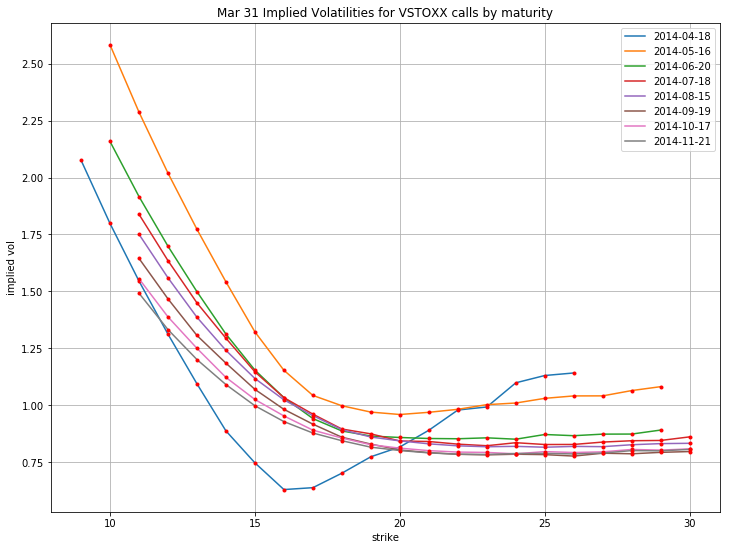

In [33]:
fig = plt.figure(figsize=(12,9))
axes = fig.add_subplot(111)
#axes.set(xticks=np.arange(10,31,5))
axes.set(xlabel='strike', ylabel='implied vol', title = 'Mar 31 Implied Volatilities for VSTOXX calls by maturity')
for maturity in maturities:
    data = plot_data[options_data.MATURITY == maturity]
      # select data for this maturity
    axes.plot(data['STRIKE'], data['IMP_VOL'],
             label=maturity.date(), lw=1.5)
    axes.plot(data['STRIKE'], data['IMP_VOL'], 'r.', label='_nolegend_')
axes.grid()
axes.legend()

In [45]:
grouped = options_data.groupby(['MATURITY', 'STRIKE'])['PRICE', 'IMP_VOL']

In [46]:
grouped.sum()

PRICE   IMP_VOL
MATURITY   STRIKE                 
2014-04-18 9.0      8.85  2.076653
           10.0     7.85  1.798354
           11.0     6.85  1.545258
           12.0     5.85  1.311829
           13.0     4.85  1.093614
           14.0     3.85  0.886680
           15.0     2.90  0.746191
           16.0     2.00  0.628907
           17.0     1.35  0.637230
           18.0     0.95  0.700942
           19.0     0.70  0.773135
           20.0     0.50  0.816182
           21.0     0.40  0.889629
           22.0     0.35  0.978402
           23.0     0.25  0.991932
           24.0     0.25  1.098081
           25.0     0.20  1.130160
           26.0     0.15  1.141307
2014-05-16 10.0     9.55  2.583501
           11.0     8.55  2.287722
           12.0     7.55  2.019625
           13.0     6.55  1.772651
           14.0     5.55  1.541568
           15.0     4.55  1.321803
           16.0     3.65  1.153001
           17.0     2.90  1.042549
           18.0     2.35  0.997178
           19.0     1.90  0.969301
           20.0     1.55  0.958777
           21.0     1.30  0.968430
...                  ...       ...
2014-10-17 21.0     3.05  0.800007
           22.0     2.75  0.793606
           23.0     2.50  0.792032
           24.0     2.25  0.786002
           25.0     2.10  0.795680
           26.0     1.90  0.791775
           27.0     1.75  0.794655
           28.0     1.65  0.805166
           29.0     1.50  0.802267
           30.0     1.40  0.807755
2014-11-21 11.0    10.25  1.491739
           12.0     9.25  1.331931
           13.0     8.30  1.200219
           14.0     7.40  1.090198
           15.0     6.55  0.997171
           16.0     5.80  0.927640
           17.0     5.15  0.877416
           18.0     4.60  0.843563
           19.0     4.10  0.815121
           20.0     3.70  0.800436
           21.0     3.35  0.790126
           22.0     3.05  0.784295
           23.0     2.80  0.783218
           24.0     2.60  0.787302
           25.0     2.40  0.788001
           26.0     2.20  0.785513
           27.0     2.05  0.789343
           28.0     1.95  0.800119
           29.0     1.80  0.799061
           30.0     1.70  0.805563

[158 rows x 2 columns]

In [37]:
len(grouped.sum())

158

In [39]:
len(options_data)

158

#### Could also just reorder columns you want to keep.  Groupby not necessary as there is only 1 data point in each group created above.

In [41]:
reorder = options_data.reindex(columns=['MATURITY', 'STRIKE', 'PRICE', 'IMP_VOL'])

In [42]:
reorder

,MATURITY,STRIKE,PRICE,IMP_VOL
46178,2014-04-18,9.0,8.85,2.076653
46179,2014-04-18,10.0,7.85,1.798354
46180,2014-04-18,11.0,6.85,1.545258
46181,2014-04-18,12.0,5.85,1.311829
46182,2014-04-18,13.0,4.85,1.093614
46183,2014-04-18,14.0,3.85,0.886680
46184,2014-04-18,15.0,2.90,0.746191
46185,2014-04-18,16.0,2.00,0.628907
46186,2014-04-18,17.0,1.35,0.637230
46187,2014-04-18,18.0,0.95,0.700942
